In [17]:
import cv2
from PIL import Image
import numpy as np
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
import matplotlib.pyplot as plt
import sys
import math
from libsvm.svmutil import *

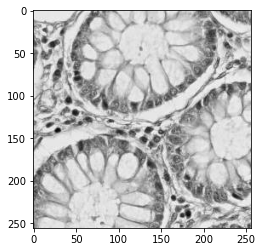

In [4]:
image = cv2.imread("C:/Users/etuna/Desktop/HW2/dataset/dataset/training/tr4.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap="gray")
plt.show()


In [5]:
def checkCoords(rows, cols, fIx, fIy, sIx, sIy):
    return fIx >= 0 and fIy >= 0 and fIx <= (rows - 1) and fIy <= (cols - 1) and sIx >= 0 and sIy >= 0 and sIx <= (rows - 1) and sIy <= (cols - 1)

In [6]:
np.set_printoptions(threshold=sys.maxsize)

In [8]:
def calculateCooccurrenceMatrix(grayImg, binNumber, di, dj):
    rows, cols = grayImg.shape
    bins = {}
    for r in range(rows):
        for c in range(cols):
            fIx = r + di
            fIy = c + dj
            sIx = r + 1 + di
            sIy = c + 1 + dj
            if not checkCoords(rows, cols, fIx, fIy, sIx, sIy):
                continue
            fpx = grayImg[fIx][fIy]
            spx = grayImg[sIx][sIy]
            if (fpx, spx) in bins:
                bins[(fpx, spx)] += 1
            else:
                bins[(fpx, spx)] = 1
            
    
    arr2Img = np.zeros(shape = (256, 256))
    for key, val in bins.items():
        arr2Img[key[0]][key[1]] = val
    
    im = Image.fromarray(np.uint8(arr2Img))
    return arr2Img
    

In [9]:
calculateCooccurrenceMatrix(gray, 0 , 0,0)

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

In [49]:
def calculateCooccurrenceMatrix(grayImg, binNumber, di, dj):
    rows, cols = grayImg.shape
    #Groups
    thr = 256/binNumber
    for r in range(rows):
        for c in range(cols):
            grayImg[r][c] = (int(grayImg[r][c]/thr) + 1 )*thr - 1
    bins = {}
    for r in range(rows):
        for c in range(cols):
            fIx = r + di
            fIy = c + dj
            sIx = r + 1 + di
            sIy = c + 1 + dj
            if not checkCoords(rows, cols, fIx, fIy, sIx, sIy):
                continue
            fpx = grayImg[fIx][fIy]
            spx = grayImg[sIx][sIy]
            if (fpx, spx) in bins:
                bins[(fpx, spx)] += 1
            else:
                bins[(fpx, spx)] = 1
            
    
    arr2Img = np.zeros(shape = (256, 256))
    for key, val in bins.items():
        arr2Img[key[0]][key[1]] = val
    
    im = Image.fromarray(np.uint8(arr2Img))
    #plt.imshow(im)
    #plt.show()
    return arr2Img
    

In [35]:
def calculateAccumulatedCooccurrenceMatrix(grayImg, binNumber, d):
    dists = [(d, 0), (d, d), (0 , d), (-d, d), (-d, 0), (-d, -d), (0, -d), (d, -d)]
    arr = np.zeros(shape=(256, 256))
    for d in dists:
        arr += calculateCooccurrenceMatrix(grayImg, binNumber, d[0], d[1])
    im = Image.fromarray(np.uint8(arr))
    return arr
    

In [165]:
def calculateCooccurrenceFeatures(accM):
    accMNormalized = normalizeAccm(accM)
    asm = angularSecondMoment(accMNormalized)
    entr = entropy(accMNormalized)
    cont = contrast(accMNormalized)
    invDiff = inverseDiffMoment(accMNormalized)
    maxProb = maxProbability(accMNormalized)
    corr = correlation(accMNormalized)
    return asm, entr, cont, invDiff, maxProb, corr
    

In [37]:
def normalizeAccm(accM):
    rows, cols = accM.shape
    puv = 0
    for r in range(rows):
        for c in range(cols):
            puv += accM[r][c]
    for r in range(rows):
        for c in range(cols):
            accM[r][c] /= puv
            #if accM[r][c] > 0:
                #print(str(accM[r][c]))
    im = Image.fromarray(np.uint8(accM))
    #plt.imshow(im)
    #plt.show()
    return accM

In [166]:
def angularSecondMoment(accMNorm):
    rows, cols = accMNorm.shape
    asm = 0
    for r in range(rows):
        for c in range(cols):
            asm += math.pow(accMNorm[r][c], 2)
    return asm
def entropy(accMNorm):
    rows, cols = accMNorm.shape
    entr = 0
    for r in range(rows):
        for c in range(cols):
            if accMNorm[r][c] == 0:
                continue
            entr += accMNorm[r][c] * math.log(accMNorm[r][c])
    return -entr
def contrast(accMNorm):
    rows, cols = accMNorm.shape
    cont = 0
    for r in range(rows):
        for c in range(cols):
            cont += accMNorm[r][c] * (r-c)*(r-c)
    return cont
def inverseDiffMoment(accMNorm):
    rows, cols = accMNorm.shape
    idm = 0
    for r in range(rows):
        for c in range(cols):
            idm += accMNorm[r][c] / (1 + math.pow((r - c), 2))
    return idm
def maxProbability(accMNorm):
    rows, cols = accMNorm.shape
    maxProb = 0
    for r in range(rows):
        for c in range(cols):
            if accMNorm[r][c] > maxProb:
                maxProb = accMNorm[r][c]
    return maxProb
def correlation(accMNorm):
    rows, cols = accMNorm.shape
    Ux = []
    Uy = []
    for r in range(rows):
        ux = 0
        for c in range(cols):
            ux += accMNorm[r][c]
        Ux.append(ux)
    for c in range(cols):
        uy = 0
        for r in range(rows):
            uy += accMNorm[r][c]
        Uy.append(uy)
    
    sigX = []
    sigY = []
    for r in range(rows):
        sigx = 0
        for c in range(cols):
            sigx += math.pow((r - Ux[r]), 2)*accMNorm[r][c]
        sigX.append(math.sqrt(sigx))
    for c in range(cols):
        sigy = 0
        for r in range(rows):
            sigy += math.pow((r - Uy[c]), 2)*accMNorm[r][c]
        sigY.append(math.sqrt(sigy))
    
    
    corr = 0
    for r in range(rows):
        for c in range(cols):
            if sigX[r] == 0 or sigY[c] == 0:
                continue
            corr += ( (r-Ux[r]) / sigX[r] ) * ( (c-Uy[c]) / sigY[c] ) * accMNorm[r][c]
    return corr

In [167]:
import glob
imgs_train = []
imgs_test = []
labels_train = []
labels_test = []
for img in glob.glob("C:/Users/etuna/Desktop/HW2/dataset/dataset/training/*"):
    n= cv2.imread(img)
    imgs_train.append(n)
    
for img in glob.glob("C:/Users/etuna/Desktop/HW2/dataset/dataset/test/*"):
    n= cv2.imread(img)
    imgs_test.append(n)
    
with open('C:/Users/etuna/Desktop/HW2/dataset/dataset/training_labels.txt', 'r') as file:
    labelStr = file.read().replace('\n', '')
    labels_train = list(map(int,labelStr))
    
with open('C:/Users/etuna/Desktop/HW2/dataset/dataset/test_labels.txt', 'r') as file:
    labelStr = file.read().replace('\n', '')
    labels_test = list(map(int,labelStr))
    
print("Train set size:",len(imgs_train))
print("Test set size:",len(imgs_test))
print("Train Labels size:", len(labels_train))
print("Train Labels size:", len(labels_test))


Train set size: 186
Test set size: 144
Train Labels size: 186
Train Labels size: 144


In [172]:
def prepareData(data):
    feat_data = []
    for img in data:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        accM = calculateAccumulatedCooccurrenceMatrix(gray ,8, 10)
        a,b,c,d,e,f = calculateCooccurrenceFeatures(accM)
        feat_data.append([a,b,c,d,e,f])
    return feat_data


In [173]:
feat_train = prepareData(imgs_train)
feat_test = prepareData(imgs_test)
print("Length of feat_train:", str(len(feat_train)))
print("Length of feat_test:", str(len(feat_test)))

Length of feat_train: 186
Length of feat_test: 144


In [171]:
print(feat_train[0])

[0.2302702453001464, -1.9869232197766729, 0.0, 0.6936784448795463, 0.42496200337340867, 4.926128742537485]


In [238]:
def balanceTrainingSets(data, labels):
    mdata = normalizeFeatures(data)
    label_dict = {}
    for l in labels:
        if l in label_dict:
            label_dict[l] += 1
        else:
            label_dict[l] = 1
    minEl = 9999
    minLabel = -1
    for k, v in label_dict.items():
        if v < minEl:
            minEl = v
            minLabel=k
            
    for k, v in label_dict.items():
        if k == minLabel:
            label_dict[k] = minEl
        else:
            label_dict[k] = minEl + (label_dict[k]-minEl)/2

    newData = []
    newLabels = []
    
    for i, d in enumerate(mdata):
        label= labels[i]
        if label_dict[label] > 0:
            newData.append(d)
            newLabels.append(label)
            label_dict[label] -= 1
    return newData, newLabels
            
    

In [236]:
def normalizeFeatures(features):
    #print(features)
    mins = np.min(features, axis = 0)
    maxs = np.max(features, axis = 0)
    newFeatures = []
    for i, f in enumerate(features):
        mf = (f - mins)/(maxs-mins)
        #print(f)
        #print(mins)
        #print(maxs)
        #print(mf)
        #print("\n\n\n")
        newFeatures.append(mf)
    #print("newfeats:")
    #print(newFeatures)
    return features
        

In [296]:
def getClassAccuricies(result, actual):
    correctDict = {}
    for i, r in enumerate(result):
        actVal = actual[i]
        if actVal == r:
            if actVal in correctDict:
                correctDict[actVal] += 1
            else:
                correctDict[actVal] = 1

    actualDict = {}
    for a in actual:
        if a in actualDict:
            actualDict[a] += 1
        else:
            actualDict[a] = 1
    mres = {}
    for r in correctDict:
        corr = correctDict[r]
        act = actualDict[r]
        mres[r] = (corr/act)
        
    return mres
        

In [295]:
feat_train_balanced, labels_training_balanced = balanceTrainingSets(feat_train, labels_train)
prob = svm_problem(labels_training_balanced,feat_train_balanced)
param = svm_parameter()
param.C=1
param.kernel_type=LINEAR
model = svm_train(prob, param)
svm_save_model("LINEAR_C1_mdl",model)
result = svm_predict(labels_train, feat_train, model)
result2 = svm_predict(labels_test, feat_test, model)
mres=getClassAccuricies(result[0], labels_train)
print(result[0])
print(labels_train)
print("Results :", mres)

Accuracy = 66.129% (123/186) (classification)
Accuracy = 42.3611% (61/144) (classification)
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
[1.0, 1.0, 3.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 3.0, 2.0, 1.0, 3.0, 1.0, 3.0, 1.0, 3.0, 1.0, 1.0, 3.0, 3.0, 1.0, 3.0, 3.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 1.0, 1.0, 1.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 3.0, 2.0, 2.0, 2

In [299]:
feat_train_balanced, labels_training_balanced = balanceTrainingSets(feat_train, labels_train)
prob = svm_problem(labels_training_balanced,feat_train_balanced)
param = svm_parameter()
param.C=0.1
param.kernel_type=LINEAR
model = svm_train(prob, param)
svm_save_model("LINEAR_C01_mdl",model)
result = svm_predict(labels_train, feat_train, model)
result2 = svm_predict(labels_test, feat_test, model)
mres=getClassAccuricies(result[0], labels_train)
mres2=getClassAccuricies(result2[0], labels_test)
print("Results :", mres)
print("Results :", mres2)

Accuracy = 55.3763% (103/186) (classification)
Accuracy = 40.2778% (58/144) (classification)
Results : {1: 0.4166666666666667, 2: 0.7159090909090909, 3: 0.39473684210526316}
Results : {1: 0.20833333333333334, 2: 0.7719298245614035, 3: 0.10256410256410256}


In [281]:
feat_train_balanced, labels_training_balanced = balanceTrainingSets(feat_train, labels_train)
prob = svm_problem(labels_training_balanced,feat_train_balanced)
param = svm_parameter()
param.C=10
param.kernel_type=LINEAR
model = svm_train(prob, param)
svm_save_model("LINEAR_C10_mdl",model)
result = svm_predict(labels_train, feat_train, model)
result = svm_predict(labels_test, feat_test, model)
mres=getClassAccuricies(result[0], labels_test)
print("Results :", mres)

Accuracy = 68.8172% (128/186) (classification)
Accuracy = 40.9722% (59/144) (classification)
Results : {1: 0.125, 2: 0.7192982456140351, 3: 0.3076923076923077}


In [302]:
feat_train_balanced, labels_training_balanced = balanceTrainingSets(feat_train, labels_train)
prob = svm_problem(labels_training_balanced,feat_train_balanced)
param = svm_parameter()
param.C=1000
param.kernel_type=LINEAR
model = svm_train(prob, param)
svm_save_model("LINEAR_C1000_mdl",model)
result = svm_predict(labels_train, feat_train, model)
result2 = svm_predict(labels_test, feat_test, model)
mres=getClassAccuricies(result[0], labels_train)
mres2=getClassAccuricies(result2[0], labels_test)
print("Results :", mres)
print("Results :", mres2)

Accuracy = 65.0538% (121/186) (classification)
Accuracy = 40.9722% (59/144) (classification)
Results : {1: 0.5833333333333334, 2: 0.7613636363636364, 3: 0.5}
Results : {1: 0.16666666666666666, 2: 0.7017543859649122, 3: 0.28205128205128205}


In [303]:
feat_train_balanced, labels_training_balanced = balanceTrainingSets(feat_train, labels_train)
prob = svm_problem(labels_training_balanced,feat_train_balanced)
param = svm_parameter()
param.C=5000
param.kernel_type=LINEAR
model = svm_train(prob, param)
svm_save_model("LINEAR_C5000_mdl",model)
result = svm_predict(labels_train, feat_train, model)
result2 = svm_predict(labels_test, feat_test, model)
mres=getClassAccuricies(result[0], labels_train)
mres2=getClassAccuricies(result2[0], labels_test)
print("Results :", mres)
print("Results :", mres2)

Accuracy = 63.9785% (119/186) (classification)
Accuracy = 44.4444% (64/144) (classification)
Results : {1: 0.45, 2: 0.7954545454545454, 3: 0.5789473684210527}
Results : {1: 0.16666666666666666, 2: 0.7368421052631579, 3: 0.358974358974359}


In [284]:
feat_train_balanced, labels_training_balanced = balanceTrainingSets(feat_train, labels_train)
prob = svm_problem(labels_training_balanced,feat_train_balanced)
param = svm_parameter()
param.C=0.1
param.kernel_type=RBF
param.gamma=0.1
model = svm_train(prob, param)
svm_save_model("RBF_C01_mdl",model)
result = svm_predict(labels_train, feat_train, model)
result = svm_predict(labels_test, feat_test, model)
mres=getClassAccuricies(result[0], labels_test)
print("Results :", mres)

Accuracy = 47.3118% (88/186) (classification)
Accuracy = 39.5833% (57/144) (classification)
Results : {2: 1.0}


In [304]:
feat_train_balanced, labels_training_balanced = balanceTrainingSets(feat_train, labels_train)
prob = svm_problem(labels_training_balanced,feat_train_balanced)
param = svm_parameter()
param.C=1
param.kernel_type=RBF
param.gamma=1
model = svm_train(prob, param)
svm_save_model("RBF_C1_mdl",model)
result = svm_predict(labels_train, feat_train, model)
result2 = svm_predict(labels_test, feat_test, model)
mres=getClassAccuricies(result[0], labels_train)
mres2=getClassAccuricies(result2[0], labels_test)
print("Results :", mres)
print("Results :", mres2)

Accuracy = 88.7097% (165/186) (classification)
Accuracy = 43.75% (63/144) (classification)
Results : {1: 0.8, 2: 0.9318181818181818, 3: 0.9210526315789473}
Results : {1: 0.20833333333333334, 2: 0.8596491228070176, 3: 0.10256410256410256}


In [286]:
feat_train_balanced, labels_training_balanced = balanceTrainingSets(feat_train, labels_train)
prob = svm_problem(labels_training_balanced,feat_train_balanced)
param = svm_parameter()
param.C=10
param.kernel_type=RBF
param.gamma=10
model = svm_train(prob, param)
svm_save_model("RBF_C10_mdl",model)
result = svm_predict(labels_train, feat_train, model)
result = svm_predict(labels_test, feat_test, model)
mres=getClassAccuricies(result[0], labels_test)
print("Results :", mres)

Accuracy = 93.0108% (173/186) (classification)
Accuracy = 43.0556% (62/144) (classification)
Results : {1: 0.0625, 2: 1.0, 3: 0.05128205128205128}


In [287]:
feat_train_balanced, labels_training_balanced = balanceTrainingSets(feat_train, labels_train)
prob = svm_problem(labels_training_balanced,feat_train_balanced)
param = svm_parameter()
param.C=100
param.kernel_type=RBF
param.gamma=100
model = svm_train(prob, param)
svm_save_model("RBF_C100_mdl",model)
result = svm_predict(labels_train, feat_train, model)
result = svm_predict(labels_test, feat_test, model)
mres=getClassAccuricies(result[0], labels_test)
print("Results :", mres)

Accuracy = 94.086% (175/186) (classification)
Accuracy = 39.5833% (57/144) (classification)
Results : {2: 1.0}


In [305]:
feat_train_balanced, labels_training_balanced = balanceTrainingSets(feat_train, labels_train)
prob = svm_problem(labels_training_balanced,feat_train_balanced)
param = svm_parameter()
param.C=1000
param.kernel_type=RBF
param.gamma=1000
model = svm_train(prob, param)
svm_save_model("RBF_C1000_mdl",model)
result = svm_predict(labels_train, feat_train, model)
result2 = svm_predict(labels_test, feat_test, model)
mres=getClassAccuricies(result[0], labels_train)
mres2=getClassAccuricies(result2[0], labels_test)
print("Results :", mres)
print("Results :", mres2)

Accuracy = 94.086% (175/186) (classification)
Accuracy = 39.5833% (57/144) (classification)
Results : {1: 0.8166666666666667, 2: 1.0, 3: 1.0}
Results : {2: 1.0}


In [289]:
feat_train_balanced, labels_training_balanced = balanceTrainingSets(feat_train, labels_train)
prob = svm_problem(labels_training_balanced,feat_train_balanced)
param = svm_parameter()
param.C=5000
param.kernel_type=RBF
param.gamma=5000
model = svm_train(prob, param)
svm_save_model("RBF_C5000_mdl",model)
result = svm_predict(labels_train, feat_train, model)
result = svm_predict(labels_test, feat_test, model)
mres=getClassAccuricies(result[0], labels_test)
print("Results :", mres)

Accuracy = 94.086% (175/186) (classification)
Accuracy = 39.5833% (57/144) (classification)
Results : {2: 1.0}
